# For Windows
1. Please download the latest SasView v5 package from
   https://github.com/SasView/sasview/tags
2. Install SasView
3. Adjust the *sasviewProgramPath* variable accordingly for the path where SasView was installed.

## In case of error
<pre style="background: #fdd">
    CalledProcessError: Command '['gcc', ...
</pre>
Please start the previously installed SasView at least once and create a plot with the desired model function. This will build the selected model from C-sources into a python library in the directory <br />
`C:\Users\{user}\.sasmodels\compiled_models\sas32_{model}.so`

If it still fails, it might be caused by OpenCL being installed while the *pyopencl* package can not be imported in jupyter notebook/lab. Try to disable OpenCL entirely by setting `os.environ["SAS_OPENCL"] = "none"` early in the code and check that the desired SasView model was build already (see above).

# McSAS example

In [1]:
# these need to be loaded at the beginning to avoid errors related to relative imports (ImportWarning in h5py)
# might be related to the change of import style for Python 3.5+. Tested on Python 3.7 at 20200417
import sys, os, pandas, numpy, scipy
# these packages are failing to import in McHat if they are not loaded here:
import h5py
from scipy.special import j0
import scipy.optimize

import warnings
warnings.filterwarnings('error')

In [2]:
def pdhParse(filename):
    skiprows, nrows = 5, -1
    with open(filename) as fd:
        nrows = [ln for ln, line in enumerate(fd.readlines())
                     if line.startswith("<?xml")]
    return skiprows, nrows[0]-skiprows

def plot(df):
    ax = df.plot("Q", "I", yerr="ISigma")
    ax.set_xscale("log"); ax.set_yscale("log"); ax.set_ylim((1e-7,1e-2))

def prepMeasData(df):
    return dict(Q = [df.Q.values], I = df.I.values,
                ISigma = df.ISigma.values)

%matplotlib inline
import matplotlib.pyplot as plt
def plotResults(measData, mcAna):
    rect = [0.1, 0.1, 0.8, 0.8]
    a1 = plt.axes(rect)
    for i in range(len(histRanges)):
        mode = mcAna.averageMode(i)
        mcAna.debugPlot(i, alpha=0.5,
            label="hist. {}={:.1f}".format(
                histRanges.iloc[i].parameter.title(),
                mode['mean'].valMean))
    def setAxes(ax, vert, horiz):
        for ax, loc in (ax.xaxis, vert), (ax.yaxis, horiz):
            ax.set_label_position(loc)
            getattr(ax, 'tick_'+loc)()
    setAxes(a1, 'top', 'right')
    plt.xlabel("R (nm)")
    plt.ylabel("Frequency")

    a2=plt.axes(rect, frameon=False)
    setAxes(a2, 'bottom', 'left')
    barWidth = numpy.diff(measData["Q"][0])
    barWidth = numpy.array((barWidth[0],) + tuple(barWidth))*.5
    plt.errorbar(measData["Q"][0], mcAna.modelIAvg.modelIMean,
                 yerr=mcAna.modelIAvg.modelIStd,
                 elinewidth=1, label="MC fit", zorder=2)
    plt.plot(measData["Q"][0], measData["I"],
             label="Input Data", linewidth=4, zorder=1)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Q (1/nm)")
    plt.ylabel("I (1/m)")

    combined = [x for a in (a2, a1)
                  for x in zip(*a.get_legend_handles_labels())]
    a2.legend(*list(zip(*combined)), loc=4)

In [3]:
# load required modules

homedir = os.path.expanduser("~")
# disable OpenCL for multiprocessing on CPU
os.environ["SAS_OPENCL"] = "none"
# set location where the SasView/sasmodels are installed
sasviewPath = os.path.join(homedir, "AppData", "Local", "SasView")
if sasviewPath not in sys.path:
    sys.path.append(sasviewPath)
from mcsas3 import McHat

In [4]:
# import data
datafile = r"S2870 BSA THF 1 1 d.pdh"
from pandas import read_csv
skiprows, nrows = pdhParse(datafile)
qs = read_csv(datafile, sep=r'\s+', skiprows=skiprows, nrows=nrows,
              header = None, names = ["Q", "I", "ISigma"])

In [5]:
# run the Monte Carlo method
measData = prepMeasData(qs)
mh = McHat.McHat(
    modelName="mono_gauss_coil", nContrib=300, modelDType="default",
    fitParameterLimits={"rg": (1, 20)},
    staticParameters={"background": 0, "i_zero": 0.00319},
    maxIter=1e5, convCrit=.45, nRep=50, nCores=0, seed=None)
mh.run(measData, "results.h5")

McSAS analysis with 50 repetitions took 2107.6s with 4 threads.
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Optimization of repetition 0 started:
chiSqr: 3.855416609658465, N accepted: 0 / 0
chiSqr: 3.855412249615917, N accepted: 1 / 1
chiSqr: 0.4577334088565305, N accepted: 355 / 1001
chiSqr: 0.4500708240603806, N accepted: 519 / 2001
Final chiSqr: 0.4499806944870345, N accepted: 522

Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Optimization of repetition 4 started:
chiSqr: 3.8646095757973637, N accepted: 0 / 0
chiSqr: 3.863705607424039, N accepted: 1 / 1
chiSqr: 0.46456381314437534, N accepted: 361 / 1001
chiSqr: 0.4501396079676316, N accepted: 565 / 2001
Final chiSqr: 0.44993898691798195, N accepted: 575

Exception ignored in: <_io.FileIO nam

In [6]:
# histogram the determined size contributions
from mcsas3.mcmodelhistogrammer import McModelHistogrammer
from mcsas3.mcanalysis import McAnalysis
histRanges = pandas.DataFrame([dict(
                parameter="rg", nBin=25, binScale="linear",
                presetRangeMin=0.1, presetRangeMax=30,
                binWeighting="vol", autoRange=False),])
mcres = McAnalysis("results.h5", measData, histRanges, store=True)

Getting List of repetitions...
50 repetitions found in McSAS file results.h5
Histogramming every repetition and extracting elements to average...


Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/Users/brian/anaconda3/envs/notebook37/lib/python3.7/site-packages/sasmodels/models/mono_gauss_coil.c' mode='rb' closefd=True

Averaging population modes...
Averaging histograms...
Averaging optimization parameters...
Averaging model intensity...


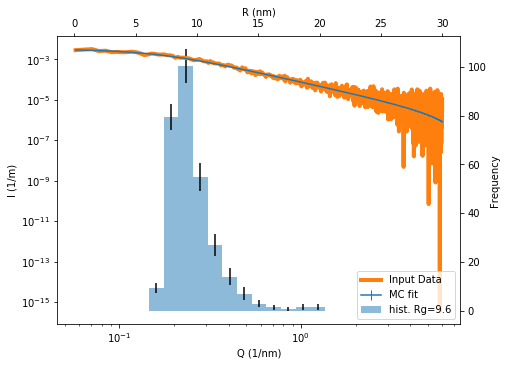

In [7]:
# plotting the intensity match and histogram
plt.figure(figsize=(7,5))
plotResults(measData, mcres)

In [16]:
measData['Q'][0].shape

(900,)